# Walking using the Linear Inverted Pendulum Model

In this exercise, we will use the linear inverted pendulum model (LIPM) seen in class as a model for bipedal walking and we will derive a model predictive control law that will stabilize walking in face of external disturbances.

The LIPM can be derived from the (complicated) dynamics of any legged robot. It describes the dynamics of the Center of Mass (CoM) of the robot when we assume that the CoM height is constant and that the angular momentum at the CoM is 0.

<img src="lipm.png" alt="missing LIPM figure" width="400"/>

In this case, the motion of the CoM in the horizontal plane (forward and side motions) can be written as a linear dynamical system. In particular, the forward and side motions are decoupled. In the following, we will only consider forward motions and ignore side movement. The forward motion of the CoM, using this model, can be written
$$\begin{align}\dot{x} &= v \\ \dot{v} &= \omega(x - u)\end{align}$$
where $x$ is the CoM position, $v$ its velocity, $\omega = \frac{g}{z}$, $z$ is the CoM height, $g$ the gravity constant and $u$ is the center of pressure (CoP) location on the ground.

We know that, to be physically consistent, the CoP needs to be located inside the support polygon formed by the feet on the ground. In the case where one foot is on the ground, the CoP needs to be inside the foot.

Since the differential equation is linear, we can explicitly solve it for a given $\Delta t$ assuming a constant center of pressure during that time. We then get the following linear discrete system
$$\begin{bmatrix} x_{n+1} \\ v_{n+1} \end{bmatrix} = \begin{bmatrix} \cosh(\omega \Delta t) & \omega^{-1} \sinh(\omega \Delta t) \\ \omega \sinh(\omega \Delta t) & \cosh(\omega \Delta t) \end{bmatrix} \begin{bmatrix} x_{n} \\ v_{n} \end{bmatrix} + \begin{bmatrix} 1 - \cosh(\omega \Delta t) \\ -\omega \sinh(\omega \Delta t) \end{bmatrix} u_n$$

The idea is to find CoP locations (which will then be realized by an another controller on the real robot) such that we can move the CoM where we want and such that the CoP is always inside the support polygon. We will assume that there is only one leg touching the ground at a time. Assuming that the foot on the ground is located at time $n$ at $f_n$ and that the foot has a length of $l_{foot}$, the CoP constraint reads
$$f_n - \frac{l_{foot}}{2} <u_n<f_n + \frac{l_{foot}}{2}$$
We will also assume that we predefine the foot step locations in advance.

We now have almost all the ingredients necessary to construct an optimal control problem. We just need a cost function. Here, to keep the problem simple, we will assume that during walking, we try to keep the CoM above the foot in contact as much as possible and that we try to keep the CoP at the center of the foot as much as possible. We will also try to keep the velocity of the CoM as small as possible. We therefore have the following optimal control problem
$$\min_{u_n} \sum_{n=0}^{N-1} \left( \begin{matrix} x_n - f_n \\ v_n \end{matrix} \right) ^T Q \left(\begin{matrix} x_n - f_n \\ v_n \end{matrix}\right) + (u_n - f_n)^T R (u_n - f_n) + \left( \begin{matrix} x_N - f_N \\ v_N \end{matrix}\right)^T Q_N \left(\begin{matrix} x_N - f_N \\ v_N \end{matrix}\right)$$
subject to
$$\begin{bmatrix} x_{n+1} \\ v_{n+1} \end{bmatrix} = \begin{bmatrix} \cosh(\omega \Delta t) & \omega^{-1} \sinh(\omega \Delta t) \\ \omega \sinh(\omega \Delta t) & \cosh(\omega \Delta t) \end{bmatrix} \begin{bmatrix} x_{n} \\ v_{n} \end{bmatrix} + \begin{bmatrix} 1 - \cosh(\omega \Delta t) \\ -\omega \sinh(\omega \Delta t) \end{bmatrix} u_n$$
and
$$f_n - \frac{l_{foot}}{2} <u_n<f_n + \frac{l_{foot}}{2}$$

In [1]:
# setup matplotlib for nice display in Jupyter
%matplotlib notebook

# a few libraries we will need
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mp

import cvxopt

# note in order to use the animation package to display movies you will need to install ffmpeg
# on Mac with homebrew: brew install ffmpeg
# on ubuntu: apt-get install ffmpeg
# on windows: https://ffmpeg.org/download.html#build-windows
import matplotlib.animation as animation

import IPython

np.set_printoptions(precision=5,linewidth=120,suppress=True)

## Solving a constrained linear optimal control problem

We provide the function below to solve LQ optimal control problems with constraints as we have seen in class. We will use this solver to construct a model predictive controller for walking. The function solves problems of the form
$$\min_{u_n} \sum_{n=0}^{N-1} x_n^T Q_n x_n + q_n^T x_n + u_n^T R_n u_n + r_n^T u_n$$
subject to
$$x_{n+1} = A x_n + B u_n,\qquad x_0 = x(0)$$
and
$$G_n \begin{bmatrix}x_n \\ u_n \end{bmatrix} \leq h_n$$
where the dynamics is independent of $n$ and the costs and bounds can change at every time step.

In [2]:
def solve_mpc_collocation(A,B,Q,q,R,r,G_bounds, h_bounds, horizon_length, x0):
    """
    Here we want to do MPC with a collocation approach
    we assume that A and B are constant but Q, q, R, r and the bounds are given as list of vectors/matrices
    one per time step
    
    it returns a state trajectory and a control trajectory
    """
    # the number of states we will need to optimize for
    num_states = x0.size*horizon_length
    u_size = B.shape[1]
    # the number of control to optimize
    num_control = u_size*horizon_length
    # the total number of variables we need to optimize
    num_vars = num_states + num_control

    # the total Hessian of the problem (the quadratic part) [x u]^T Qtot [x u]
    Qtilde = np.zeros([num_vars, num_vars])
    # the total linear part
    qtilde = np.zeros([num_vars, 1])
    
    Atilde = np.zeros([num_states, num_vars])
    btilde = np.zeros([num_states])
    # we impose the initial condition x0
    btilde[0:x0.size] = -A.dot(x0)
    
    G_tilde = None
    h_tilde = None


    for i in range(horizon_length):
        # we put Q and R in the right places on the diagonal
        Qtilde[x0.size*i:x0.size*(i+1), x0.size*i:x0.size*(i+1)] = Q[i]
        Qtilde[num_states+u_size*i:num_states+u_size*(i+1), num_states+u_size*i:num_states+u_size*(i+1)] = R[i]
       
        # same for q and r
        qtilde[i*x0.size:(i+1)*x0.size] = q[i]
        qtilde[num_states+i*u_size:num_states+(i+1)*u_size] = r[i]
    
        # we construct the equality constraint for the dynamics
        Atilde[x0.size*i:x0.size*(i+1),num_states+u_size*i:num_states+u_size*(i+1)] = B
        if i>0:
            Atilde[x0.size*i:x0.size*(i+1), x0.size*(i-1):x0.size*(i+1)] = np.hstack((A, -np.eye(x0.size)))
        else:
            Atilde[x0.size*i:x0.size*(i+1), x0.size*(i):x0.size*(i+1)] = -np.eye(x0.size)
        
        # now we construct the inequalities Gtilde [x u] <= htild
        G_tmp = np.zeros([G_bounds[i].shape[0], num_vars])
        G_tmp[:, x0.size*i:x0.size*(i+1)] = G_bounds[i][:,:x0.size]
        G_tmp[:, num_states+u_size*i:num_states+u_size*(i+1)] = G_bounds[i][:,x0.size:]
        if G_tilde is None:
            G_tilde = G_tmp
        else:
            G_tilde = np.vstack((G_tilde, G_tmp))

        if h_tilde is None:
            h_tilde = h_bounds[i]
        else:
            h_tilde = np.vstack((h_tilde, h_bounds[i]))
        
            
    # we transform our data into cvxopt complicant data
    Qtot = cvxopt.matrix(Qtilde)
    p = cvxopt.matrix(qtilde)
    
    G = cvxopt.matrix(G_tilde)
    h = cvxopt.matrix(h_tilde.flatten())
    
    Atilde = cvxopt.matrix(Atilde)
    btilde = cvxopt.matrix(btilde)
    
    #now we call cvxopt to solve the quadratic program constructed above
    cvxopt.solvers.options['show_progress'] = False
    sol = cvxopt.solvers.qp(Qtot,p,G,h,Atilde, btilde)
    x = np.array(sol['x'])
    u = x[num_states:]
    x = x[0:num_states]

    return  np.vstack((x0, x.reshape([horizon_length, x0.size]))).T, u.T

## Simulation of the LIPM

In [3]:
class LIPM:
    """
    This class implements a linear inverted pendulum model - we will use it to simulate the walking robot
    """
    
    def __init__(self):
        """
        constructor of the class
        """        
        #gravity constant
        self.g=9.81
        
        #CoM height
        self.z_com = 1.0

        #integration step (100ms)
        self.dt = 0.1
        
        #
        self.omega = np.sqrt(self.g / self.z_com)
        
        #the transition matrices
        self.A = np.array([[np.cosh(self.dt*self.omega), 1./self.omega * np.sinh(self.dt*self.omega)],
                          [self.omega * np.sinh(self.dt*self.omega), np.cosh(self.dt*self.omega)]])
        self.B = np.array([[1 - np.cosh(self.dt*self.omega)],[-self.omega * np.sinh(self.dt*self.omega)]])
        
        # half of the size of the foot (i.e. the foot is 30cm long)
        self.foot_size = 0.15        
                        
    def next_state(self,x,u):
        """
        Inputs:
        x: state of the system as a numpy array (x,v)
        u: cop position as a scalar
        
        Output:
        the new state as a numpy array
        """
        
        return self.A.dot(x) + self.B.dot(u)
        
    
    def simulate(self, x0, controller, horizon_length, foot_steps, noise=True):
        """
        This function simulates the LIPM for horizon_length steps from initial state x0
        
        Inputs:
        x0: the initial conditions as a numpy array (x,v)
        controller: a function that takes a state x as argument and index i of the time step and returns a control u
        horizon_length: the horizon length
        foot_steps: an array containing foot step locations for every time step (this is used to ensure u is constrained to the support polygon)
        
        Output:
        x[2xtime_horizon+1] and u[1,time_horizon] containing the time evolution of states and control
        """
        x=np.empty([2, horizon_length+1])
        x[:,0] = x0
        u=np.empty([1,horizon_length])
        for i in range(horizon_length):
            u[:,i] = np.clip(controller(x[:,i],i), foot_position[i]-self.foot_size, foot_position[i]+self.foot_size)
            x[:,i+1] = self.next_state(x[:,i], u[:,i])
            if i>0 and noise:
                disturbance = np.random.normal(0., 0.01)
                x[1,i+1] += disturbance
        return x, u

## Animation and plotting utility

In [4]:
def animate_walker(plotx, plotu, foot_pose):
    """
    This function makes an animation showing the behavior of the LIPM with some graphics showing the CoP, etc.
    takes as input the result of a simulation (with dt=0.1s), the CoP position (plotu) and the foot step locations fn (foot_pose)
    """
    use_dt = 100
    
    feet_colors = ['b','g']
    c_foot_c = 0
    
    fig = mp.figure.Figure(figsize=[8.5,2.4])
    mp.backends.backend_agg.FigureCanvasAgg(fig)
    ax = fig.add_subplot(111, autoscale_on=False, xlim=[-0.2,9], ylim=[-.2,2.3])
    ax.grid()
    
    list_of_lines = []
    
    #plot the ground
    ax.plot([-0.1,8],  [0,0])
    
    #create the walker
    line, = ax.plot([], [], feet_colors[c_foot_c], lw=2)
    list_of_lines.append(line)
    #for the CoP
    line, = ax.plot([], [], 'or', ms=8)
    list_of_lines.append(line)
    #for the CoM
    line, = ax.plot([], [], 'ok', ms=10)
    list_of_lines.append(line)
    #for the torso
    line, = ax.plot([], [], 'k', lw=2)
    list_of_lines.append(line)
    #for the head
    line, = ax.plot([], [], 'ok', ms=10)
    list_of_lines.append(line)
    #for the foot
    line, = ax.plot([], [], 'k', lw=2)
    list_of_lines.append(line)
    
    com_height = 1.
    torso_height = 1.
    
    def animate(i):
        nonlocal c_foot_c
        for l in list_of_lines: #reset all lines
            l.set_data([],[])
        if i>0:
            if foot_pose[i] != foot_pose[i-1]:
                c_foot_c = (c_foot_c + 1)%2
                list_of_lines[0].set_color(feet_colors[c_foot_c])
                                        
        list_of_lines[0].set_data([foot_pose[i], plotx[0,i]], [0, com_height])
        list_of_lines[1].set_data([plotu[0,i], plotu[0,i]], [0, 0])
        list_of_lines[2].set_data([plotx[0,i], plotx[0,i]], [com_height, com_height])
        list_of_lines[3].set_data([plotx[0,i], plotx[0,i]], [com_height, com_height+torso_height])
        list_of_lines[4].set_data([plotx[0,i], plotx[0,i]], [com_height+torso_height, com_height+torso_height])
        list_of_lines[5].set_data([foot_pose[i]-0.15, foot_pose[i]+0.15], [0, 0])
        
        return list_of_lines
    
    def init():
        return animate(0)

    ani = animation.FuncAnimation(fig, animate, np.arange(0, len(plotx[0,:-1])),
        interval=use_dt, blit=True, init_func=init)
    plt.close(fig)
    plt.close(ani._fig)
    IPython.display.display_html(IPython.core.display.HTML(ani.to_html5_video()))

In [5]:
def plot_results(x_real, u_real, x_plan, u_plan):
    """ this function plots the results of the simulations"""
    
    time = np.linspace(0,horizon_length*walking_model.dt, len(x_real[0,:]))
    plt.figure(figsize=[8,5])
    # plt.subplot(3,1,1)
    plt.plot(time, x_real[0,:], linewidth=6, label='Simulated CoM')
    plt.plot(time, x_plan[0,:], '--', linewidth=6, label='Planned CoM')
    plt.ylim([-1,10])
    plt.xlabel('Time [s]')
    plt.ylabel('CoM position')
    plt.legend()

    plt.figure(figsize=[8,5])
    plt.plot(time, x_real[1,:], linewidth=6, label='Simulated CoM Vel')
    plt.plot(time, x_plan[1,:], '--', linewidth=6, label='Planned CoM Vel')
    plt.ylim([-1,2])
    plt.xlabel('Time [s]')
    plt.ylabel('CoM velocity')
    plt.legend()

    plt.figure(figsize=[8,5])
    plt.plot(time[:-1], u_plan[0,:] - foot_position, linewidth=6, label='Planned CoP in foot')
    plt.plot(time[:-1], u_real[0,:] - foot_position, '--', linewidth=6, label='Simulated CoP in foot')
    plt.plot(time[:-1], np.zeros([len(foot_position)]) + walking_model.foot_size, 'k--', label='upper foot limit')
    plt.plot(time[:-1], np.zeros([len(foot_position)]) - walking_model.foot_size, 'k--', label='lower foot limit')
    plt.xlabel('Time [s]')
    plt.ylabel('CoP position and limits')
    plt.legend()
    
    plt.figure(figsize=[8,5])
    plt.plot(time, x_real[0,:], linewidth=6, label='CoM')
    plt.plot(time[:-1], u_real[0,:], linewidth=6, label='CoP')
    plt.plot(time[:-1], foot_position, 'k', label='foot position')
    plt.plot(time[:-1], foot_position + walking_model.foot_size, 'k--', label='foot boundary')
    plt.plot(time[:-1], foot_position - walking_model.foot_size, 'k--', label='foot boundary')
    plt.xlabel('Time [s]')
    plt.ylabel('Complete simulated pattern')
    plt.legend()

# Planning a walking trajectory 
We can plan a walking trajectory by solving the OC problem above as follows

<IPython.core.display.Javascript object>


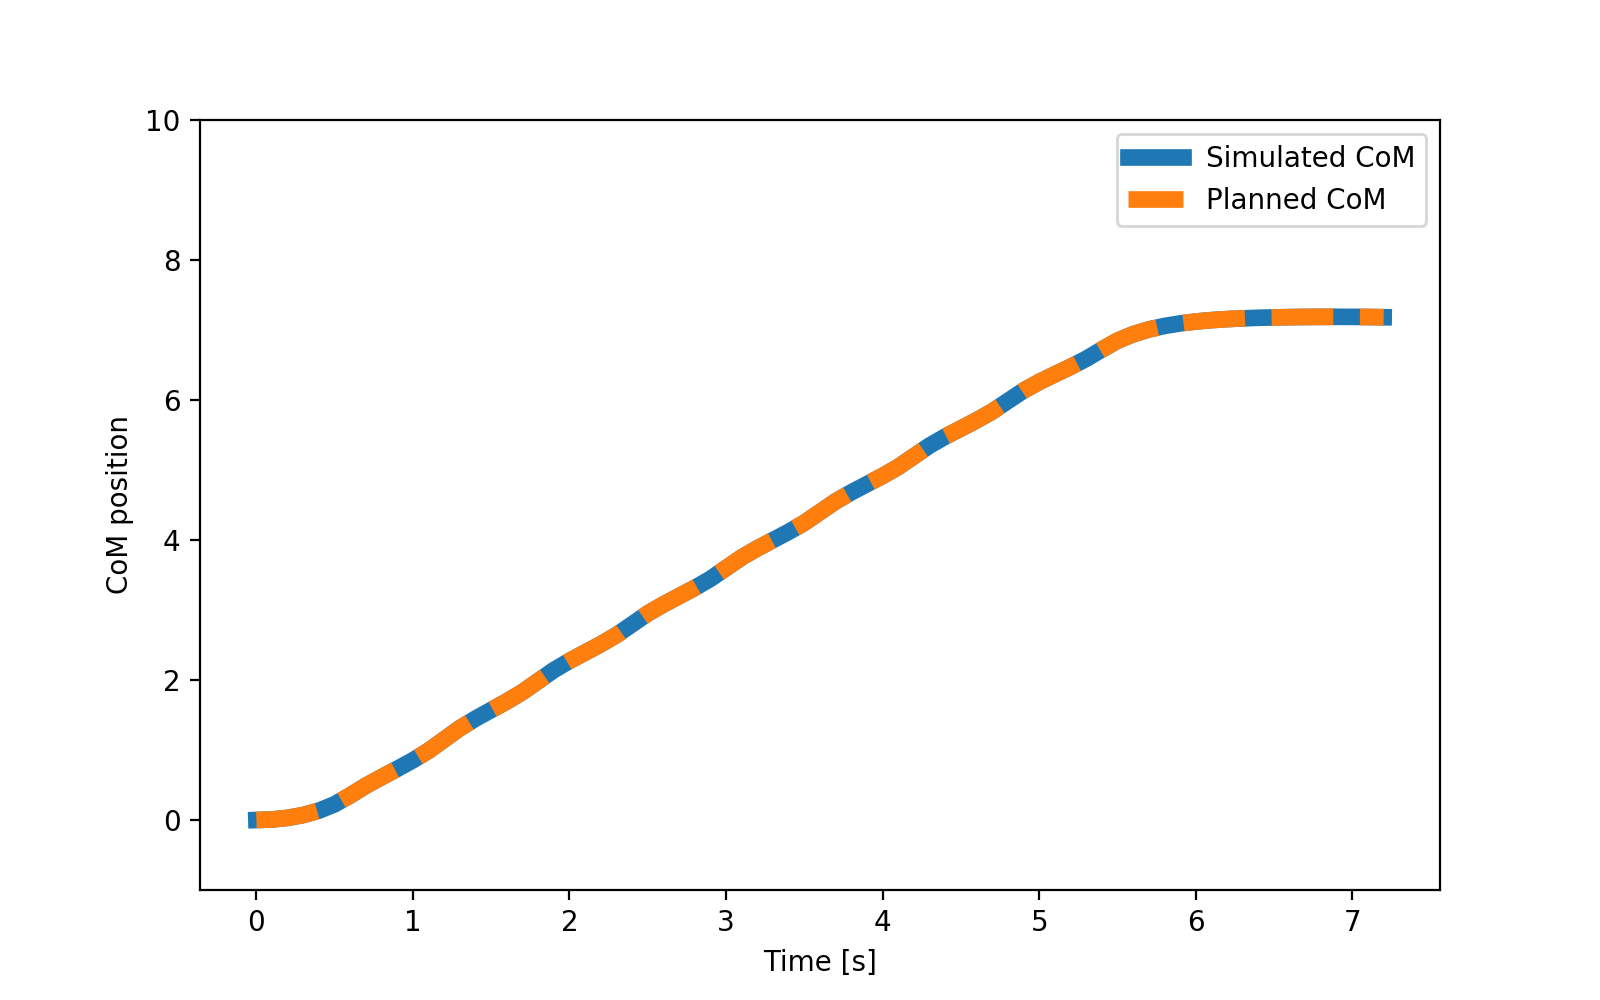

<IPython.core.display.Javascript object>


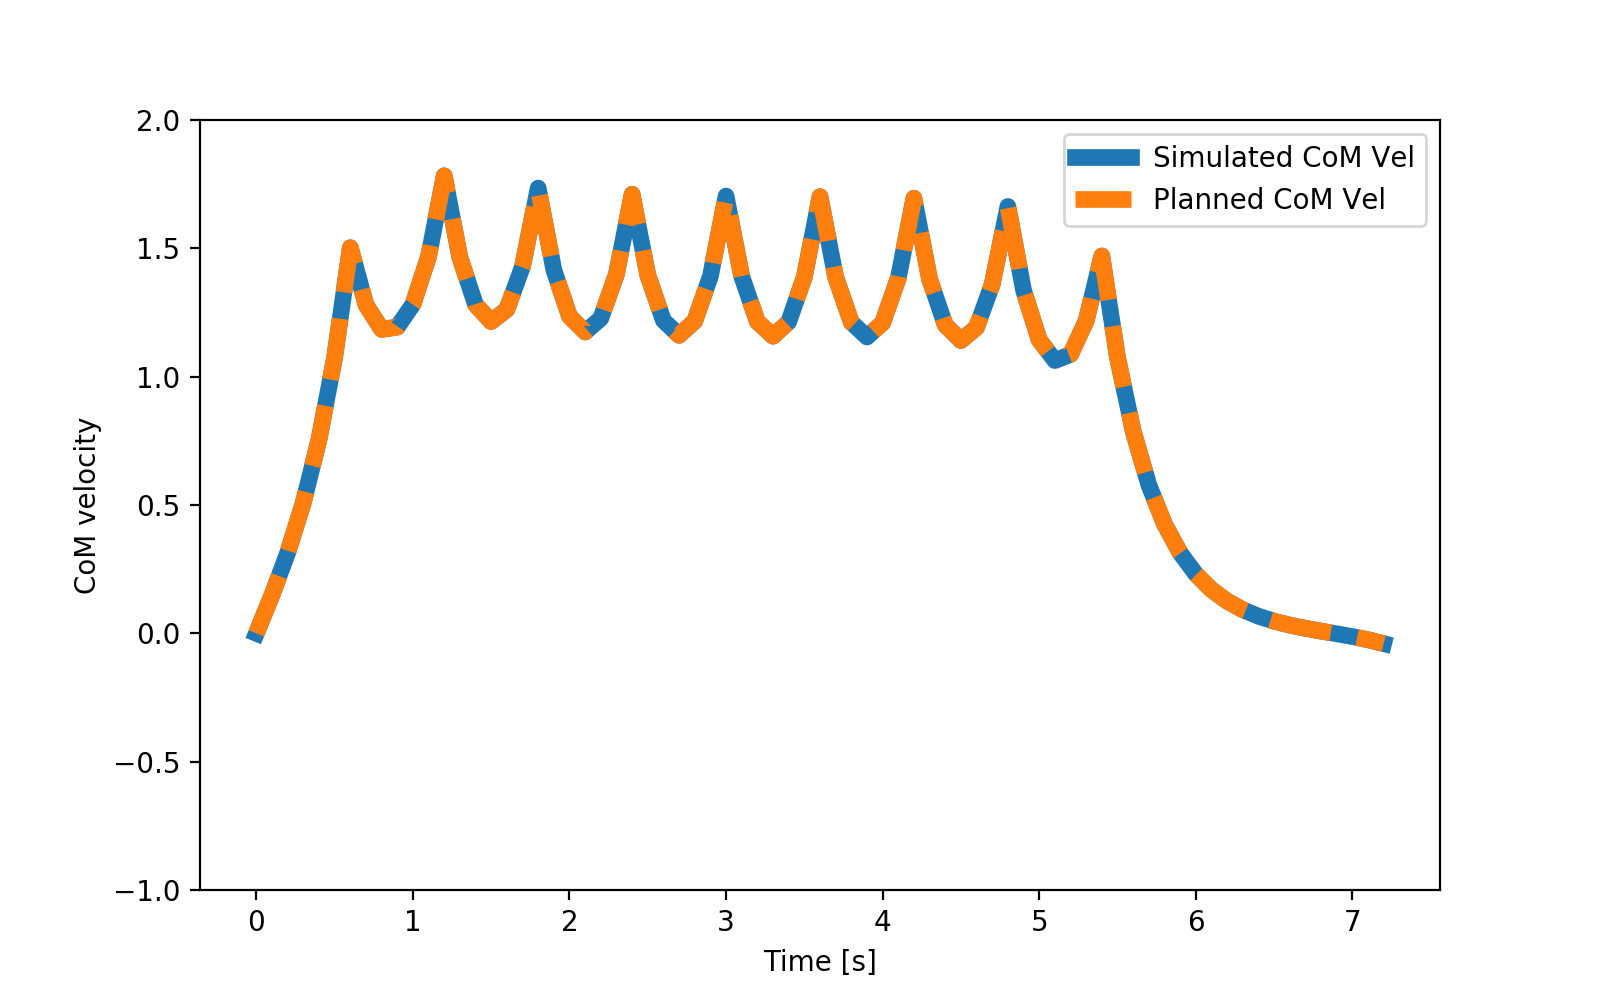

<IPython.core.display.Javascript object>


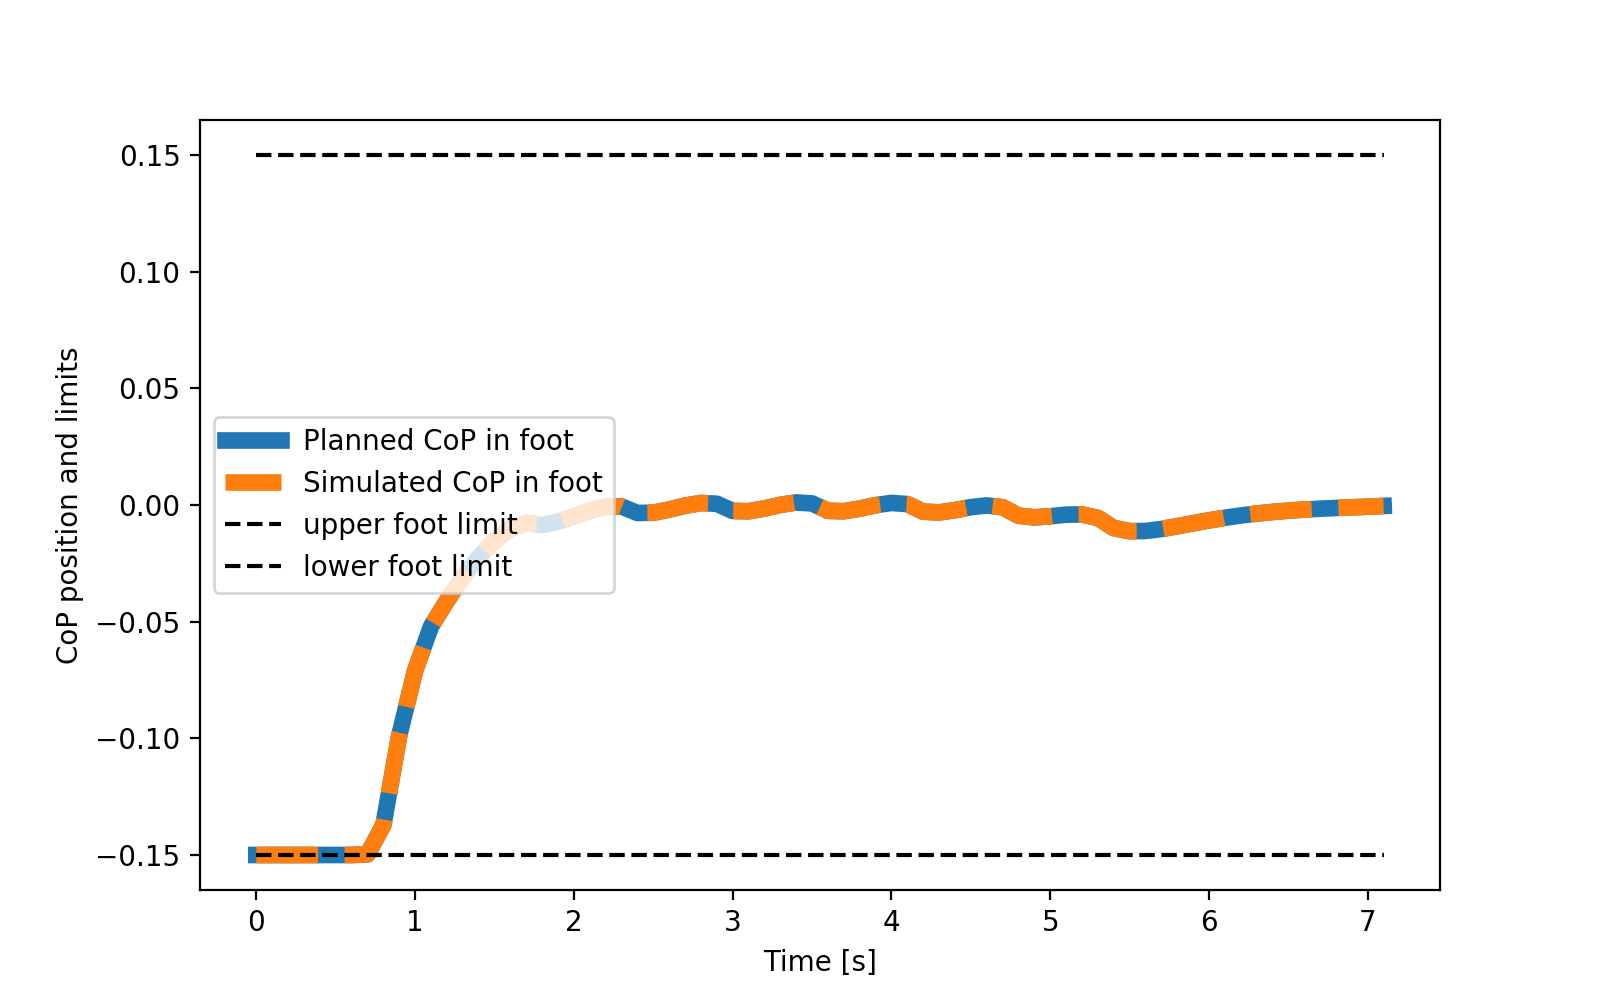

<IPython.core.display.Javascript object>


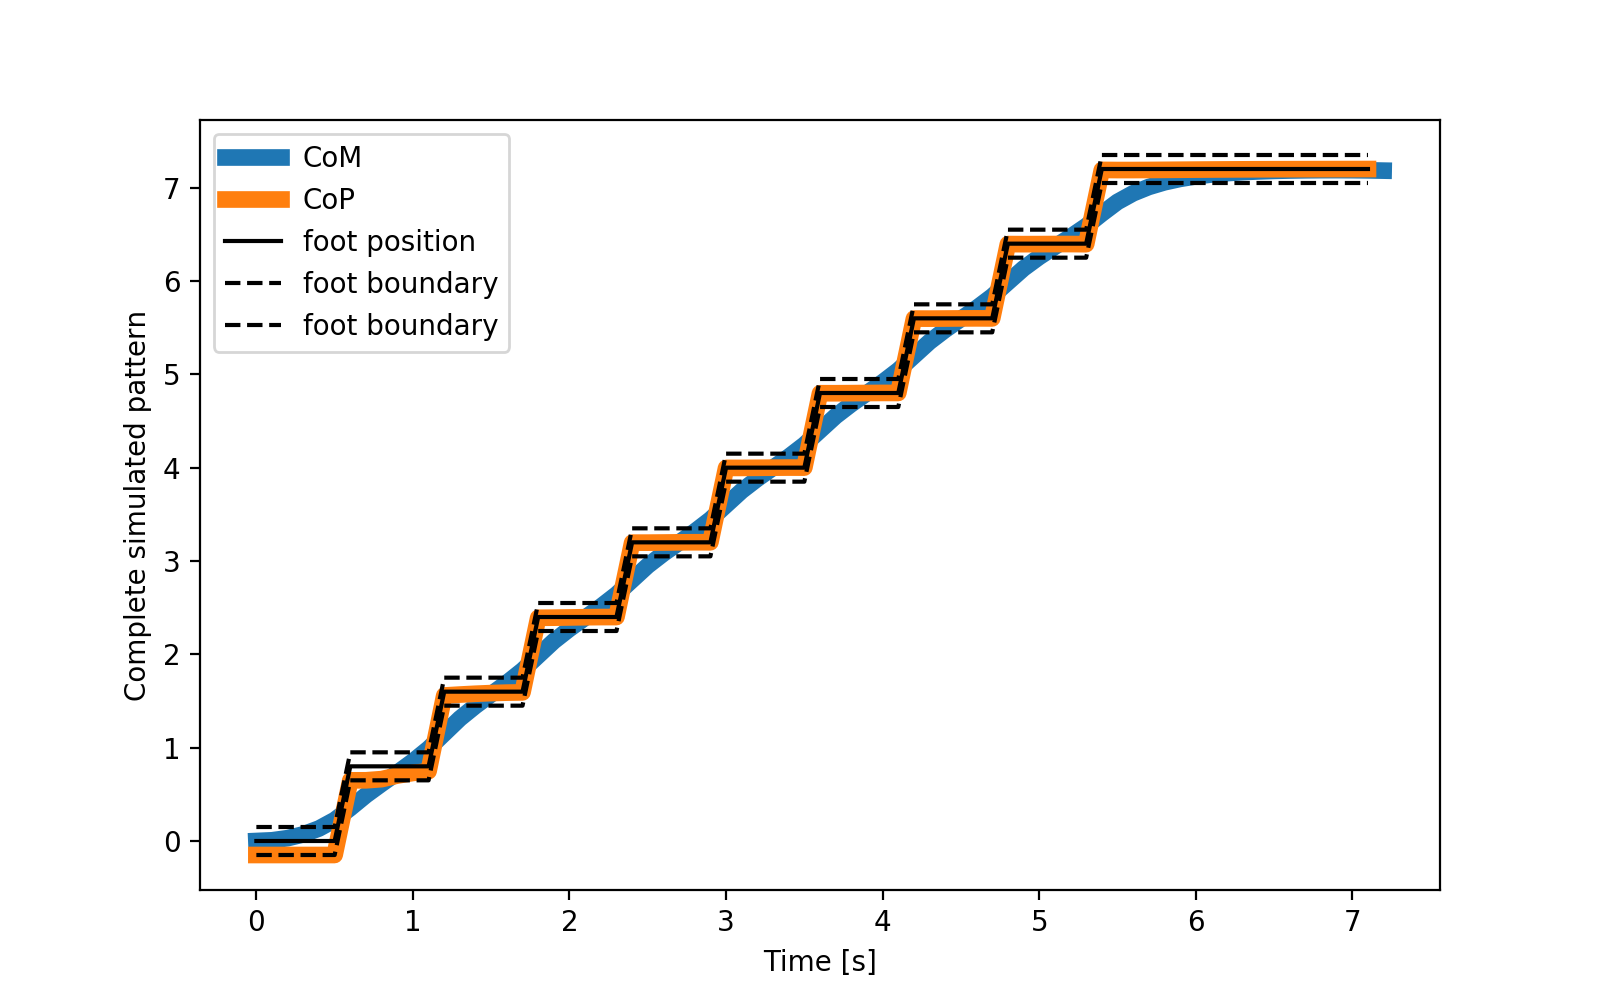

<source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAABYjW1kYXQAAAKuBgX//6rcRem9
5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTU1IHIyOTE3IDBhODRkOTggLSBILjI2NC9NUEVHLTQg
QVZDIGNvZGVjIC0gQ29weWxlZnQgMjAwMy0yMDE4IC0gaHR0cDovL3d3dy52aWRlb2xhbi5vcmcv
eDI2NC5odG1sIC0gb3B0aW9uczogY2FiYWM9MSByZWY9MyBkZWJsb2NrPTE6MDowIGFuYWx5c2U9
MHgzOjB4MTEzIG1lPWhleCBzdWJtZT03IHBzeT0xIHBzeV9yZD0xLjAwOjAuMDAgbWl4ZWRfcmVm
PTEgbWVfcmFuZ2U9MTYgY2hyb21hX21lPTEgdHJlbGxpcz0xIDh4OGRjdD0xIGNxbT0wIGRlYWR6
b25lPTIxLDExIGZhc3RfcHNraXA9MSBjaHJvbWFfcXBfb2Zmc2V0PS0yIHRocmVhZHM9NyBsb29r
YWhlYWRfdGhyZWFkcz0xIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFj
ZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJh
bWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdl
aWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MTAgc2NlbmVjdXQ9NDAgaW50cmFfcmVmcmVz
aD0wIHJjX2xvb2thaGVhZD00MCByYz1jcmYgbWJ0cmVlPTEgY3JmPTIzLjAgcWNvbXA9MC42MCBx
cG1pbj0wIHFwbWF4PTY5IHFwc3RlcD00IGlwX3JhdGlvPTEuNDAgYXE9MToxLjAwAIAAAAxhZYiE
ABD//veBvzLLXyK6yXH5530srM885DxyXYmuuNAAAAMAAAMAAAMABiMSN/6J4P4R4lcQE8kYWQT6
y3KCuinXVt83n9H0S01mbztHQVmSva4/vXAq3t9p2GeBk+t6G1IAPnWY86z/ienmnvyw6g7Vofvc
HctObctagCEdk41dOjdBxwTMv3gihBeTO2ZvQFWwO1gVYHWe0ccN50QFYa79vn1yWXD0FYjKAahj
ZKP26bT2it+CynYkUuHi2gYsRwYlSVO/+ZQIfQ+4C+XIFjpW1rX+nre3UiwZAQI9+S8/Rbtc1Uee
ZMiIvTZ8AEpZd2kWvIDkYIbh4wJqYr2vd8jziejNXstvyyuJwve38zcZk24V0ru8Pqco6IAJ6S2V
x+OKeQm6oXvLAVQaE3JbBeuy874HKmEhhJdnRNpqUe5Z6GHXDMYKP+87lS9nIcZdQVZxS73JUqO0
uiEF/SLIWOyt3GG3/D6vrorgYuSnHhFKIIykqTYlxFPPPhEq5cD4fXSeAco9ZY03sFACARTAILlP
6QUVPZkIJTJKQBD8CIDLppmrz4Y98jeOrJM7oIDCNOv9vnlqpt/l+dtvKkZDIWS79riQ9CkuPSwu
GoUBQ7HT+F0nfgWfmnOvF4LsE654rpBO/ohG3q+pvOnLGg5f6uYnzq+EfM5jGai9vHfbz5EBkVKn
bsEE7MRRgZsPhu9H+yDAFnjGgoEOTjR9I4LJta07wi7jWEUY4xUF/Wu5FSVJznZnWVQbSOeVq4XF
TYHQb8D2NwGQq3HjPZosMR+j8jcV5+qLmyFnr+m2U8iXeT3Ai3rBRrVgH2LOFk0yt0uZqVrNQzGR
Ff/758MmSMh1/o+budwZXBcZODqNRFWqLg5CxoB6ve5UQVq8cPKk4cPKu/kz9iuugOCHpbahrPF3
NfyItDAYx265738v0N1kh9FEJTF4098rmAyZb07yJ8/2DVUwJaxTy3ejxa3/E2MycBKltpvMu7Ja
79Qd/BS8Yyy9QCxhuUonRzkx8hOLkxxxhMKKrUj/61n4qdAXCpa6DCdpyxZWiWVkehyNhLfP6chJ
/5pEwtxShVdzDVj4qca9L0xVJBj35eVClwp+LycQTYW22032yU0IdwcOhQYkZaTuX9OWLLVCro90
W7n7wT+ktwrcns8b3wor2Z09+kXIIDOZxa0IPAqI17wME0EIBo2Ulwhdx77prDjorXxeglfu/6/L
NF2ycthyJ2FwhitW8aOISu1my5zPv9dINNqWJ6ToTcoCWiwXAslNN2scKoxXKYgwtm8J9VPi7bSF
DKKZtv7/3DUpdtauBrtPjBnNrP7cLliVVkcz0/4/gOIXfp2SmRT9V+A+VEIrvvtywhRSp1xljakN
U4mTefDPOnEhsMT8vgh7bpp0f6i5p1hqP1GU8TNAMC7bN9c/yiNQZokd1hW+St0D+YFxse/+o7Op
zYLkOfiV9y6XrHx0qT65VNwzb7uwA+yE2gaFPUlVsIBV7Cc9dlzAN4vRaaJOx6kZBVYjIzlh7bw6
YGnDUCoeaBK3rPrGL1glNeKEqmgxR/SSy8uh6igu/VLCxKWHB99jehwdh1mXu87gYi2aNeuKOLZg
Pb4uGQeTSz2uCbxYdWYngMHu/PutOgTLd4bSMId/HmOeWkS1RTXG99kUvX/TcBnxjPPx039T+ChB
QADOf+gzWW3WY1dZyDdEZE6u6str0JqAkCyWwsafkJVKyuc/DO1uv6PEWYV4u5xWPVS/8ww2BtrK
OnBDgCbEbNckPRUkvru6AOuqm//7PiKLQZpgr0IjBrnnflOsEL8Kze7HnG9RdOhefqK2BLY3WHTF
ixfAez3XpGRBwXF8wmCv6Tb+Mx5SdoMzRl9U1RiFhnOXn29d2Jc+/JdS2rXCQOSfC8t4Qu1cDw/c
60Us9rDv8OW4ocTpxgaNICUujELGkEByyf/eQEXvYjpxW/S3+/lKSSIKqEZfnaverqbb+wxz07Xd
QOI46tthEirhvrWhmK+/F+pLDcUjZQgr+dhi0BFJn7oVxvRzw5dVbv6DBdhLWeScsjWEEN+OZoLh
SZNhCh6AQtaIn3wOH3fgrbkP1bJWAywScFRuQUrH/eOtT6U4hxJHzmbDJxF/rFkUwrVPfSWNTRbp
hPH3naQKbY0qE73Vz5U/mH3g9yLX14CK+F92pUKORfwOK33yK91Wfu0Liu9QDpaJEOeBy430HKBf
SK6F11d7IiIvLD/Pu7x1DyCOo6iy6RrZOd95hdI5yA0nGlSPDSwSDNgriZoXsd2MXXZprZWIxQ4T
nlq7b6i3/yf9C6fugszH+4ONm1QQdd3PAkwiVJrvwBAHjgsljPOvdSU0pD2EgRYpV/Ui0j1YTdXx
N0FT1EFt8DG1P1Z5v0AGhb+27z/hAq1crHPAQuQaf+Ip8xi4TnFNIUgVUW+yuqKIq9yGdJGcUkiv
mXm6P2BWmX4TMOuInWYMARrPHQbVpzSaIcLPQnO83ZFUEJniv9ZKq09RH5yst+sTJaO1y802+rcR
EowV2T7B+2baj4N8xLKnCOtX+9DfGdnZGEYk3NV8Gwi1dtC20T2B8jyYwr+S6VM14TW2t0Ak/ohe
DIGh8jgIgDEx5EBmr6/URYhANGoyivvP7nv9wZuar/4w1GfD9E/OLKUPciOzzs3i6RkRNQvdQXX/
WV1pXOo+1NMt8wmOLwdDAlVk+Epc1yK4xeKqJ7WyZM8+3JZfUjesO8Sy5/mWmhVpIfOzm2Jbv7F8
6ynlHsMVCJghNRuF8rU5QfFkFeIkbv0lQRpOE5JJNtFesyDad8Z0ouXul7WaYXXSHn7be13muLDz
kIoiSNDZbdCC00eDrOPYjK0IVdXryUPZL1BLY+pmwcOw9j/GqCw97V+n8xZDapcb0Jrl3Pd2L6oX
LI25lhIN6P+czV9jLDaNC

In [6]:
# first lets create a walking model
walking_model = LIPM()

# assume we start at rest
x0 = np.array([0.,0.])

# we set the time taken by the robot to take one full step
step_time = 0.7 #in seconds
iterations_per_step = int(step_time / walking_model.dt)

# the length of a step is 0.8 meters
step_length = 0.8

# we would like to make 10 steps and then stop
num_steps = 10

# the horizon length including the number of steps and two cycles without stepping
horizon_length = num_steps * iterations_per_step + 2 * iterations_per_step

# now we create a vector that contains the desired foot locations at every time step
foot_position = np.zeros([horizon_length])

# for the 10 steps
for i in range(num_steps):
    foot_position[i*iterations_per_step:(i+1)*iterations_per_step] = i*step_length
# for the last cycle we stay in place
foot_position[num_steps*iterations_per_step:] = (num_steps-1)*0.8

# now we can construct the optimal control problem as follows
# we will define bounds of the form G_bounds [x u]^T < h_bounds
G_bounds = []
h_bounds = []
# the cost function is rewritten in the form 0.5(x u)^T Q (x u) + q^T x + 0.5uRu + r^T u to take into account the linear terms
Q = []
q = []
R = []
r = []

# we will fill the lists for each time step
for i in range(horizon_length):
    Q_nominal = np.eye(2)
    Q.append(Q_nominal)
    # we want the CoM above the foot and 0 velocity
    q.append(Q_nominal.dot(np.array([[-foot_position[i]],[0.]])))
    
    R_nominal = 100*np.eye(1)
    R.append(R_nominal)
    # we want the CoP in the center of the foot
    r.append(R_nominal.dot(np.array([-foot_position[i]])))
    
    # we create bounds for the CoP location
    G_bounds.append(np.array([[0,0,1],[0,0,-1]]))
    h_bounds.append(np.array([[walking_model.foot_size+foot_position[i]],[walking_model.foot_size-foot_position[i]]]))

# now we can solve the problem using the collocation method (solving a single quadratic program gives a x and u trajectory in time)
x_plan, u_plan = solve_mpc_collocation(walking_model.A,walking_model.B,Q,q,R,r,G_bounds, h_bounds, horizon_length, x0)

# we now define a controller that will simply use the computed u as a control
feedforward_controller = lambda x,i: u_plan[0,i]

# we simulate the LIPM using the feedforward controller (no noise)
x_real,u_real = walking_model.simulate(x0, feedforward_controller, horizon_length, foot_position, noise=False)

# we plot the resulting motion vs. the motion that was planned and the associated CoP
plot_results(x_real, u_real, x_plan, u_plan)
animate_walker(x_real, u_real, foot_position)

We are able to compute a plan but when the simulation has noise (e.g. the robot gets pushed or we need to account for errors coming from the simplification of the LIPM vs. the real robot), the plan cannot get the robot to walk. This is shown below.

<IPython.core.display.Javascript object>


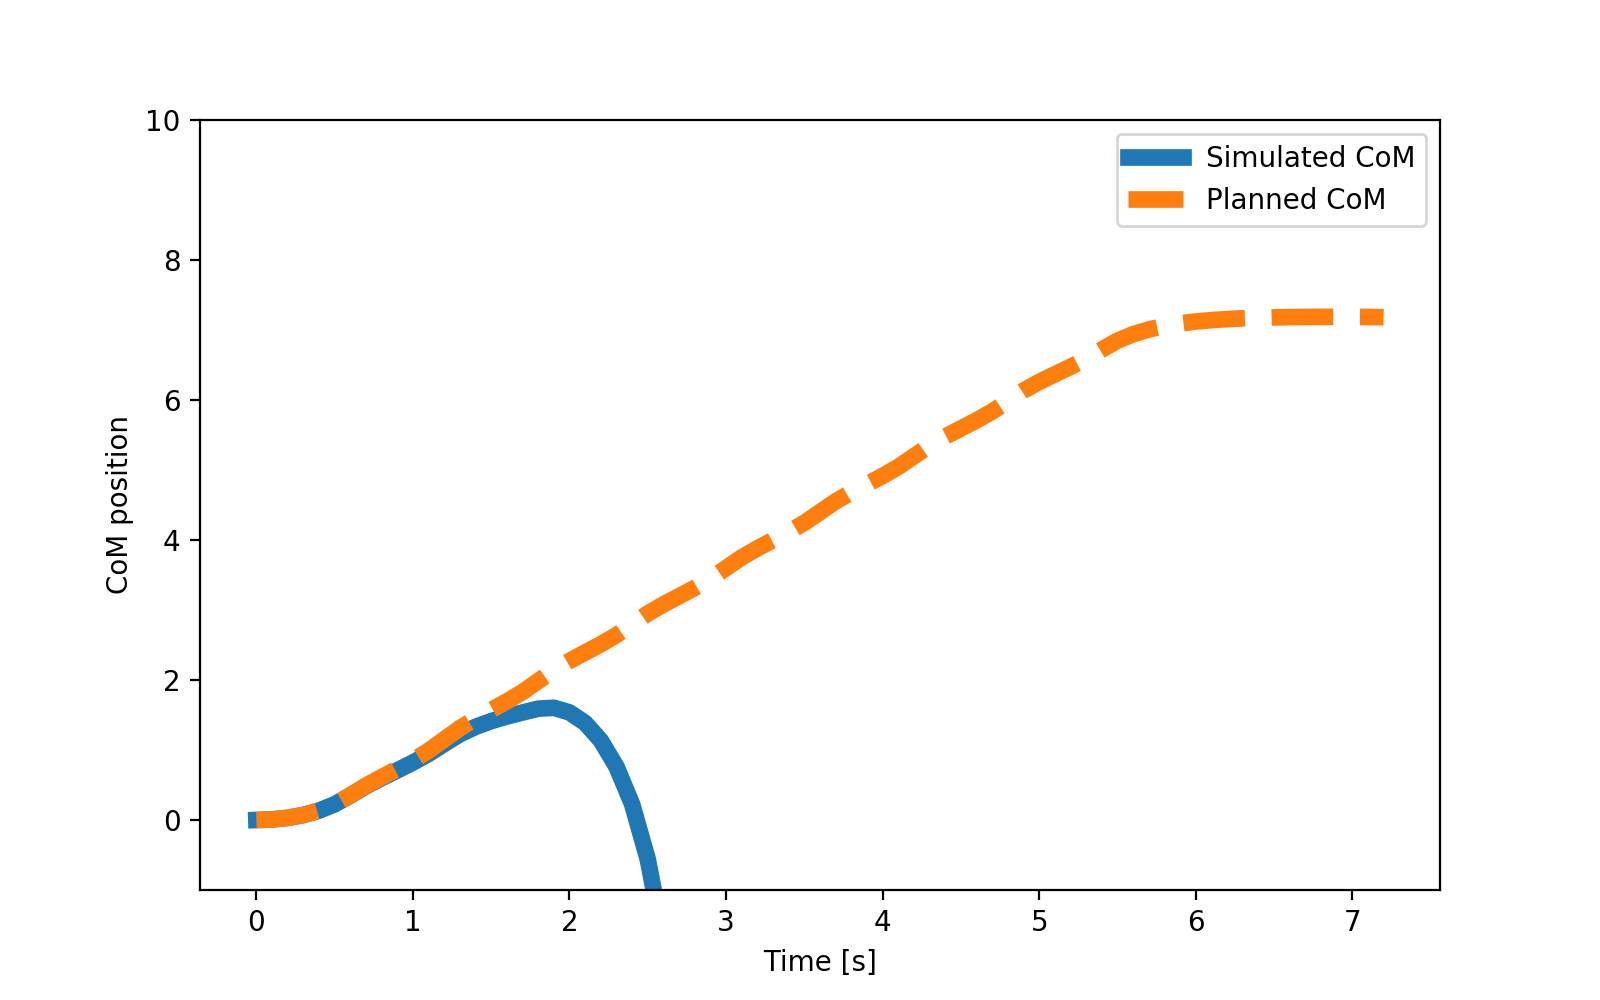

<IPython.core.display.Javascript object>


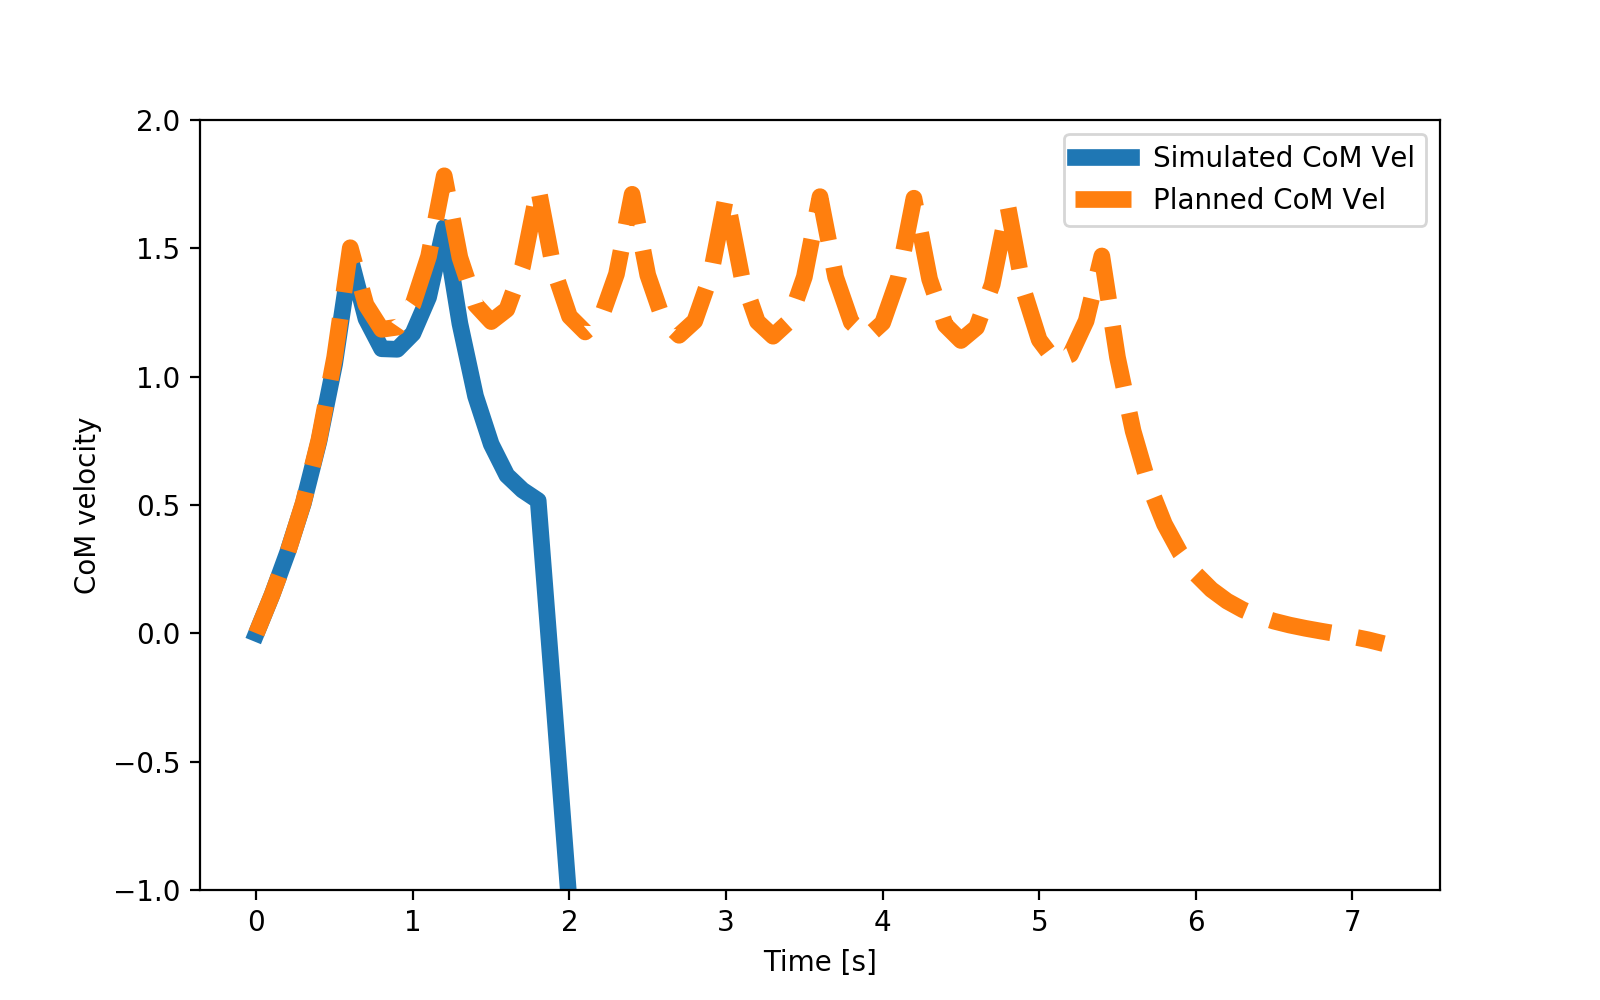

<IPython.core.display.Javascript object>


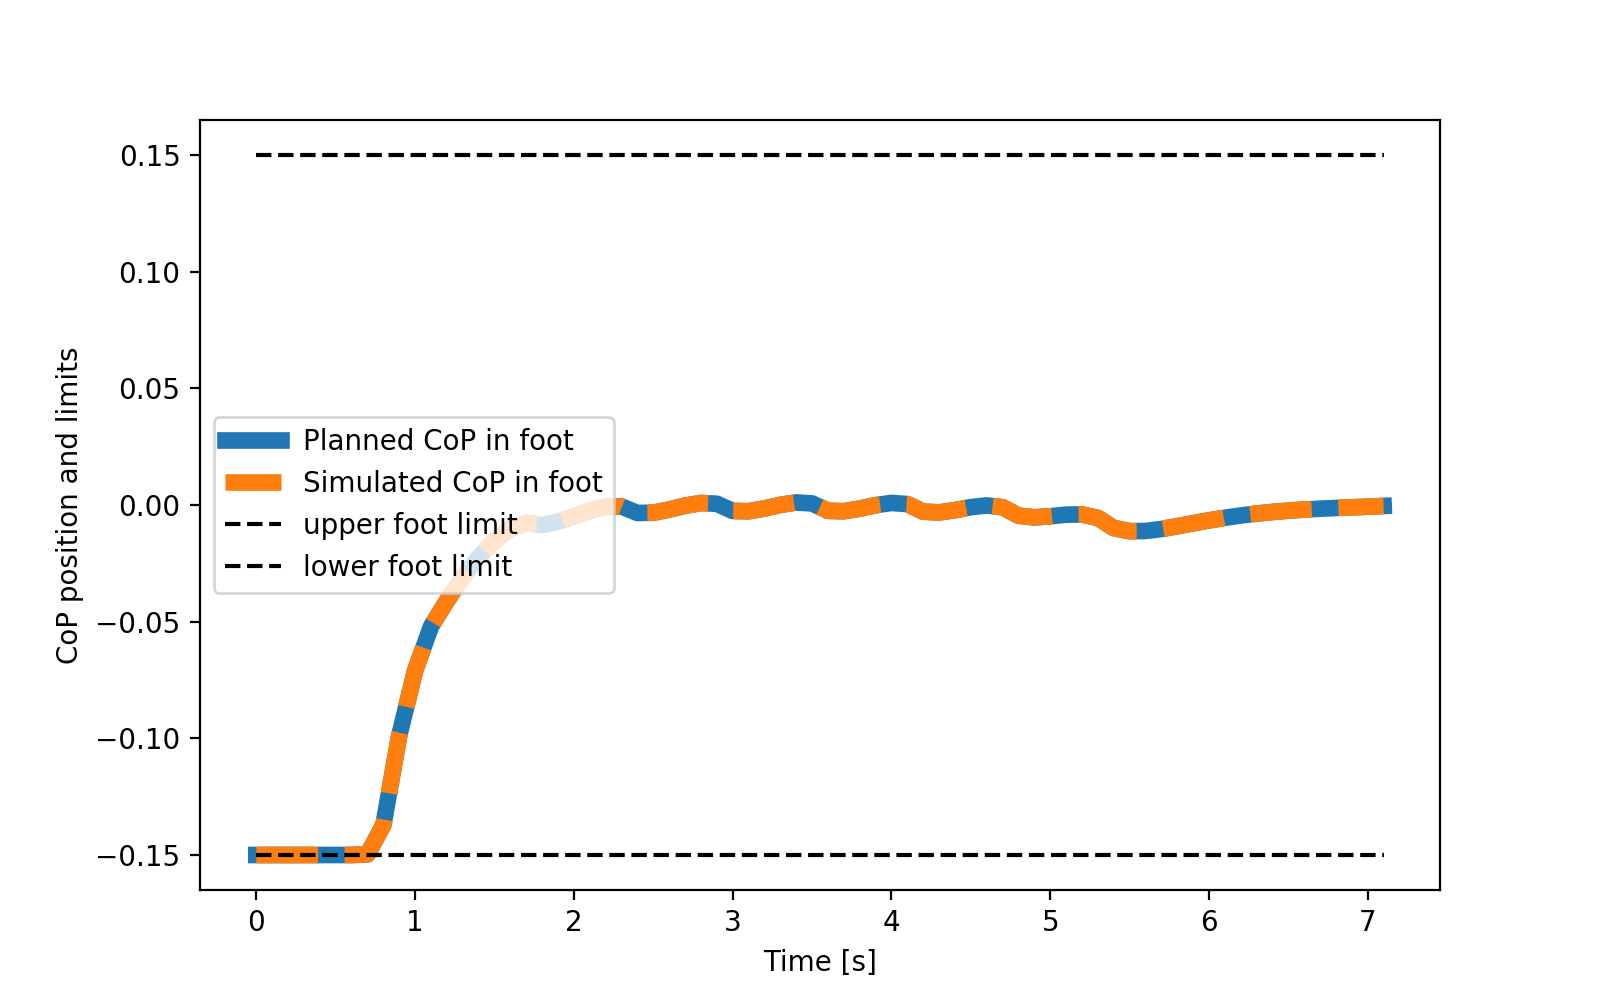

<IPython.core.display.Javascript object>


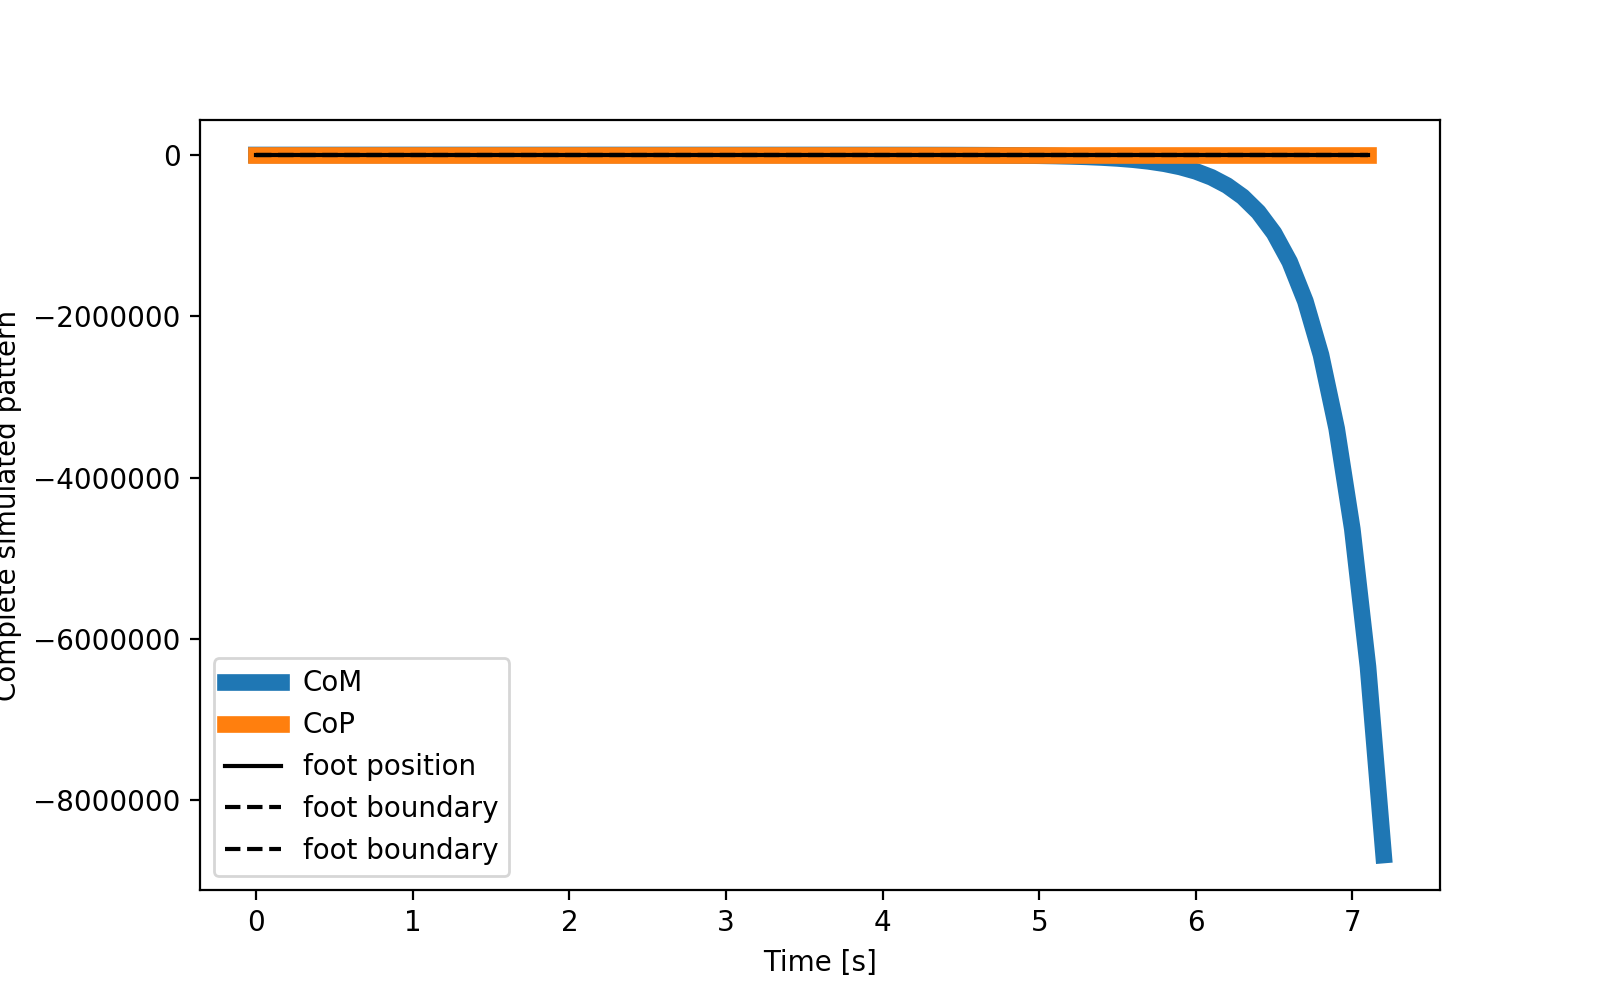

<source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAABP121kYXQAAAKuBgX//6rcRem9
5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTU1IHIyOTE3IDBhODRkOTggLSBILjI2NC9NUEVHLTQg
QVZDIGNvZGVjIC0gQ29weWxlZnQgMjAwMy0yMDE4IC0gaHR0cDovL3d3dy52aWRlb2xhbi5vcmcv
eDI2NC5odG1sIC0gb3B0aW9uczogY2FiYWM9MSByZWY9MyBkZWJsb2NrPTE6MDowIGFuYWx5c2U9
MHgzOjB4MTEzIG1lPWhleCBzdWJtZT03IHBzeT0xIHBzeV9yZD0xLjAwOjAuMDAgbWl4ZWRfcmVm
PTEgbWVfcmFuZ2U9MTYgY2hyb21hX21lPTEgdHJlbGxpcz0xIDh4OGRjdD0xIGNxbT0wIGRlYWR6
b25lPTIxLDExIGZhc3RfcHNraXA9MSBjaHJvbWFfcXBfb2Zmc2V0PS0yIHRocmVhZHM9NyBsb29r
YWhlYWRfdGhyZWFkcz0xIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFj
ZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJh
bWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdl
aWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MTAgc2NlbmVjdXQ9NDAgaW50cmFfcmVmcmVz
aD0wIHJjX2xvb2thaGVhZD00MCByYz1jcmYgbWJ0cmVlPTEgY3JmPTIzLjAgcWNvbXA9MC42MCBx
cG1pbj0wIHFwbWF4PTY5IHFwc3RlcD00IGlwX3JhdGlvPTEuNDAgYXE9MToxLjAwAIAAAAyOZYiE
ABD//veBvzLLXyK6yXH5530srM885DxyXYmuuNAAAAMAAAMAAAMABiMSN/6J4P4R4lcQE8kYWQT6
y3KCuinXVt83n9H0S01mbztHQVmSva4/vXAq3t9p2GeBk+t6G1IAPnWY86z/ienmnvyw6g7Vofvc
HctObctagCEdk41dOjdBxwTMv3gihBeTO2ZvQFWwO1gVYHWe0ccN50QFYa79vn1yWXD0FYjKAahj
ZKP26bT2it+CynYkUuHi2gYsRwYlSVO/+ZQIfQ+4C+XIFjpW1rX+nre3UiwZAQI9+S8/Rbtc1Uee
ZMiIvTac6Cqb6IQigN+xZv6HX0G1VgZK+kT7deZQiomYYxVX0xC3+gTGih15E8OX9TlJLPYfwPPI
IlLMOLdOw/e0z6+oMgW+4SsWU97aUmAacjEdbpIovCBtHxdss3M7PhhtNUxTB+fUFuKtWKvjEu/4
HqLH8Gh78RPMf44FGZR8jYtBx85ZuRaEHZP7XqwfPgJ5nksneR0zvWIKVvHXtG4vkdkJCevmE/qc
IQ3ky2nUlAjRaBDa9zTE9RDA7V1pk5D3xI+8LPC3Gy3e4Cu5NleJh3/b64ieGpy72bHj6UrNzMSI
VJujeTzFbqNQgUlHvlvxejn+WcHS8fL5fJfi8F7wIrmZR0L5106n1vXAek6Jp1Eav4mh9jihUtTZ
Z9NFvD0XhOdvYfTke7kRogH7bjvH3CvefOe/DvpzesEwXary7GGRXKeXLn1TRoZYGaM1HsE+X/+x
oFvPu92+me+usoE0mUiSOvuY5X7QjblLQqUFGmwWS2dipSK5kUKYQf16dDar3psOEpZkIjdAQFVz
UN2Lk599rizrDQIKicNpv/KCF3cZl72uqsDwBzCGPAkuPdhddhpXBTD7wnydfPb3t57t8QrUpI5y
fYcaaQYrpvjqy72C4TQWTa4TW8FyC77MySAKD2nP6pWoLE5Cp/Aie9NzqD7iSqJNjMb3dxSK7CTX
MlrFPLd6PFMB4gpqsITbxzm8s+pqhzjC+DpSiaMQ+gFjDcpROjnJjzWhL9SzCVl59Mnv6GvrbyOO
FS10GE7TliytEa5f8IYbCW+f05CQEaKx3h56rzGmkD1jfG4T3piqSDHvy8qFHwIrbJ1LvWh9qCLD
G2mAiWY+SzxIy0ncv6csWWppoB7ot3P3gn9JaH5F/DT6oworrcep+kXIIDOZxa0IKN4iqWsME0EI
Bok1G63zK+fMYKNvlLq9QMaTDaCss7XonZOCRPsOpbtSXEqresOarUE3F0sT8HGHMUlcRLVwE8Gu
/33ohuMZd/SR4+fdVCNOxhZMy85onkIQxqINAxqK2IWyKx7UT6sgmzemgpJFac58x5frtYcaMDFe
knq5QhmHY/+LMFco1pyjCbBb4qsnE6mgL/ziLU1UUimP0x1SaKaGOfTnIrQv6ilRO0DrZnkzbSki
mVOT0YZtk7UeAWemml5N/dYKIzZ3+P8PFlt9LIi4sfayGwdxl8TP7l0vWPjpUn1yqbhjWR259B9C
vInqSoZ076PCc9dlzAN4vRaaJGT6eumVYjIzlh7bw6ZLbjxJysLVyfoUNUic1FOvEy5J9yMa4Qrh
HwZmvmVCR5Sr6FRDuzVzgMig/wbpVA4dka+36MtEwCPDsuEQJjTPa2gvgA58/XN6dd6d/9teb2dx
R76G+qSHBhzmVFHV83XGVHGif9L5xzweowLCS6X5IHq9iLu6gb1kEllZ4HmCNL3WXNUHQgE3lKA/
YkW/0gPkERzCuQroTUxsyx5njv5VichvtTdyBL1l4L2gAxHK1gyr94Wcx0OHOdqGuxqLmH/0dUiR
lUfKgmFsqZH3xciaxlOER50ax9nc8qlD4EAal0fmuTHL4RXjjG6kkOoUYZs9zj8GWyEv282obC0O
i/55ptjDsKEPzuoBpZ04WWulkwQn4qXAxdaldvIO94UZ1Gq3QPbDnvYrRzp9sWISsPBwEpc/DTPz
tHVl2X13E++kLDl5zEukyqysjeY2WOOBSkBeP1tGbsU93FMwyymOrbYRIq4b61oZivvxqa4Z6UZU
ajbspNe9knHVt8c1tySxBxiROkQfJqSZT0qpD146D1tffb8CsH+Vgh33aiyDM60DmUQEb7g2kRTg
7gTg7FoDEfgH0KcN8TocYIRpH5ZCRJFqZuCopa5AWMrMqZFXGSlPZ9ZT4JnCgq9mjCB2NGjKhc36
//IepGqLfikcvwv1lBxrAM8AkSAAAFnMHQ6KkVOXe80t31ah7IKlNkHKBfSK6F10DiaxFPAwzGIJ
uoeQR1HYp4eCiIpknLxA0lgazNEpHhpYJBmwVwB53sd2MXXZprZWIw9gKvX/f/WIiUCZkLeoghZm
P9wcbNqgg69f1iTCJUmu/AEAeOe0a7fEtKmw+2YF661YzK0lNGYZgB5hhqCtZeMeZCdA+dZ/KnzU
MrjyfkbaqErzdXicqLA/9w9915kYo0HezxUG8n4Hx/WqIoMKYn3xYnGPzndIohbK/WppSAWq5DfN
I42a3ThnWpUYbHAapcysZBaRH5q5FIfSlolQyMKwdu7MPLT+3XCQ8WJ/YpOkozpA36Pw7RGQ0P+Q
86SR1+0rTuShVu9BsFnGbCCIsiAzVFDpGTZ0Z4HyPVNMIa+GK8+8uIz/0wkX8uIGNnn1kQRLEpLV
gUUVQmM5erI1viOslpIqOL2TSMafJkrx5aGPM6sk1SWFqDLcTt27cuzeLpGPCIhZocxOpvul0EAk
1n1v8/b5VXpNmYjiuGQO2aNFwMe5GQIdlN1WteJ3QRGuTXlk90bgbndKb4ofwaQf9jyGkkQCFYqJ
szMKcwLQhGyovzpqmjWy+iFBnycPue0ICwTd8DRrrmcWrRXYJ0PlOxStdl92Fh/ut+PwgIkgOR8c
enyCqux6GK+FnV1W/Hd0+

In [7]:
# we simulate the LIPM using the feedforward controller when the simulation has noise
x_real,u_real = walking_model.simulate(x0, feedforward_controller, horizon_length, foot_position, noise=True)

plot_results(x_real, u_real, x_plan, u_plan)
animate_walker(x_real, u_real, foot_position)

## Questions

a) Using the example above and the OC solver, write a model predictive controller that re-computes the optimal control at every instant of time as a function of the current state x. The idea is to solve the original OC problem for a shorter horizon and apply only the first control and repeast at every iteration.

b) What is the shortest time horizon that you can use in the MPC controller while still getting a stable walking in a noisy environment? (the simulation is stochastic so you may want to test your algorithm several times to get an "average" behavior). 

c) Relate this horizon time to the duration of one step. How many steps in advance is it necessary to plan for to get a stable controller?

d) How different is the executed control compared to the originally planned one?

e) What happens if you change the weights in the cost function? What if you increase the terminal cost (e.g. to $10^9$)? Can you decrease or increase the receding horizon length? Describe qualitatively the behavior you observe.